In [1]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
from nba_api.stats.endpoints import leaguedashptdefend, leaguedashptstats
from great_tables import GT, md, html


player_dict = get_players_pbp()
teams_dict, teams_list = get_teams()

box_DIR = "../data/box/"
img_DIR_P = "../data/images/players/"


In [2]:
year = 2023
df1 = pd.read_parquet(box_DIR+f"NBA_Box_P_Base_{year}.parquet")
df1["GAME_ID"] = df1["GAME_ID"].astype(int)
df2 = pd.read_parquet(box_DIR+f"NBA_Box_P_Adv_{year}.parquet",columns=["gameId","personId","possessions"])
df2.columns = ['GAME_ID','PLAYER_ID',"POSS"]
df3 = pd.merge(df1,df2,on=['GAME_ID','PLAYER_ID'])

In [3]:
df3["DRE"] = -8.42364*df3["POSS"]/100+0.79231*df3["PTS"]-0.71944*(df3["FGA"]-df3["FG3A"])-0.55233*df3["FG3A"]-0.15944*df3["FTA"]+0.13479*df3["OREB"]+0.3996*df3["DREB"]+0.54415*df3["AST"]+1.68007*df3["STL"]+0.76387*df3["BLK"]-1.3599*df3["TOV"]-0.10838*df3["PF"]

df3["GmSc"] = df3["PTS"]+0.4*df3["FGM"]-0.7*df3["FGA"]-0.4*(df3["FTA"]-df3["FTM"])+0.7*df3["OREB"]+0.3*df3["DREB"]+df3["STL"]+0.7*df3["AST"]+0.7*df3["BLK"]-0.4*df3["PF"]-df3["TOV"]

In [4]:
pID = get_pID("Jalen Green")
df4 = df3.query(f"PLAYER_ID == {pID}")
df4 = df4.reset_index(drop=True).reset_index()
df4["index"] +=1
df4 = df4.rename(columns={"index":"Game_No"})

In [5]:
players = ["LeBron James","Stephen Curry","Kevin Durant","Kawhi Leonard","DeMar DeRozan","Giannis Antetokounmpo","Luka Doncic","Shai Gilgeous-Alexander","Nikola Jokic","Jayson Tatum"]
players = ["Giannis Antetokounmpo","Luka Doncic","Shai Gilgeous-Alexander","Nikola Jokic","Jayson Tatum","Jalen Brunson","Anthony Edwards"]
pIDs = [get_pID(pp) for pp in players]

In [6]:
df4 = df3[df3["PLAYER_ID"].isin(pIDs)]

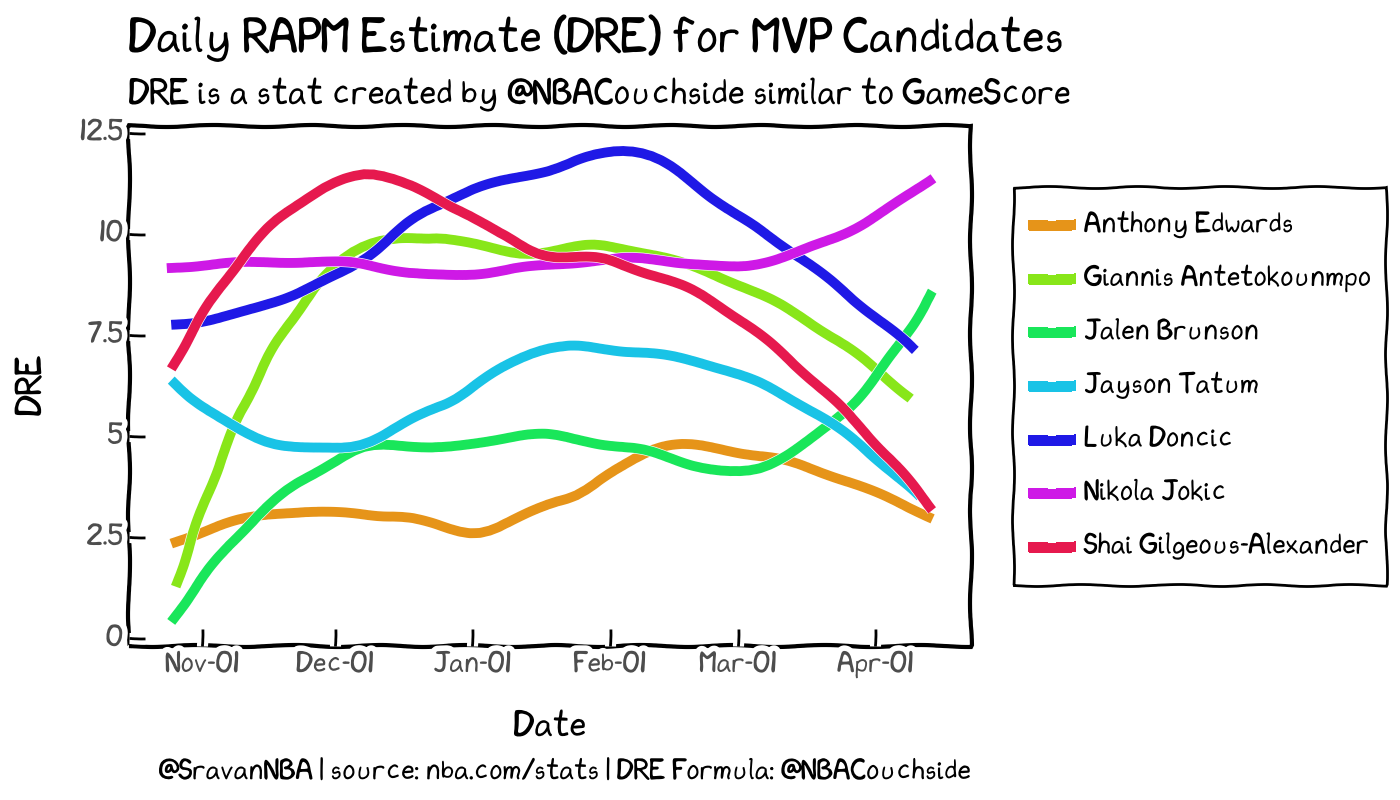

<Figure Size: (700 x 400)>

In [7]:
p = (
    ggplot(df4,aes(x="GAME_DATE",y="DRE",color="PLAYER_NAME"))
    # + geom_point()
    + geom_smooth(se=False,size=2)#method="lm")
    + theme_idv
    + scale_x_date(date_labels = "%b-%d",date_breaks = "1 month")
    # + scale_color_brewer(type="qual", palette=3)
    + scale_color_discrete(h=0.1,s=0.8,l=0.5)
    + theme(
        figure_size=(7,4),
        legend_title=element_blank(),
    )
    + labs(
        x="Date",
        title="Daily RAPM Estimate (DRE) for MVP Candidates",
        subtitle="DRE is a stat created by @NBACouchside similar to GameScore",
        caption="@SravanNBA | source: nba.com/stats | DRE Formula: @NBACouchside",
    )
)
p

In [8]:
df6 = (df3
    .query("GAME_DATE < '2024-03-01'")
    .groupby(["PLAYER_ID","PLAYER_NAME"])[["DRE"]]
    .agg({"DRE":["mean","count"]})
    .reset_index()
)
df6.columns = ["PLAYER_ID","PLAYER_NAME","DRE","GP"]
df6 = df6.query("GP >= 5")
df7 = (df3
    .query("GAME_DATE >= '2024-03-01'")
    .groupby(["PLAYER_ID","PLAYER_NAME"])[["DRE"]]
    .agg({"DRE":["mean","count"]})
    .reset_index()
)
df7.columns = ["PLAYER_ID","PLAYER_NAME","DRE","GP"]
df7 = df7.query("GP >= 5")
df8 = pd.merge(df6,df7,on=["PLAYER_ID","PLAYER_NAME"])

In [9]:
df8["Diff"] = df8["DRE_y"] - df8["DRE_x"]
df9 = df8.nlargest(10,"Diff")

In [10]:
df10 = df9[["PLAYER_ID","PLAYER_NAME","Diff"]].reset_index(drop=True).reset_index()
df10["index"] +=1
df10["PLAYER_ID"] = df10["PLAYER_ID"].astype(str)

In [11]:
t = (
    GT(df10)
    .tab_header(
        title=md("DRE Biggest Difference Before and After March 1 2024"),
        # subtitle="Daily measurements in New York City (May 1-10, 1973)"
    )
    .tab_source_note(source_note="@SravanNBA | source: nba.com/stats | DRE: @NBACouchside")
    .cols_label(
        index = "#",
        PLAYER_ID = "",
        PLAYER_NAME = "Player",
        Diff = "DRE Diff",
    )
    .cols_align(align="center")
    .cols_align(align="left", columns="PLAYER_NAME")
    .fmt_image(
        columns="PLAYER_ID",
        path = img_DIR_P,
        file_pattern="{}.png"
    )
    .fmt_number(columns="Diff", decimals=2)
    .tab_options(
        heading_title_font_size="120%",
        heading_subtitle_font_size="110%",
        # heading_title_font_weight='bold',
        table_background_color="floralwhite",
        column_labels_font_size="105%",
        column_labels_font_weight='bold',
        row_group_font_weight='bold',
        row_group_background_color="#E5E1D8",
        table_font_size=10,
        table_font_names="Consolas", 
        data_row_padding = "3px",
        table_margin_left = 1,
        table_margin_right = 1,
    )
    # .save(fig_DIR + "net_season_segment.png")
)
t.save("DRE_Mickey_Mouse.png",scale=3,expand=2,web_driver="edge")
t

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\pansr\\AppData\\Local\\Temp\\tmp44j4sgqt\\tmp0hr5hyi1.html'